# Creating Customer Segments

## Edderic Ugaddan

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [183]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ggplot import *

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


##Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer: 

Right now, I have a dataset of 440 rows and 6 columns (Fresh, Milk, Grocery, etc.) When I perform PCA, I expect the dataset to be transformed into another 440x6 matrix, where each customer's wholesale delivery is no longer represented explicitly in terms of the original columns (Fresh, Milk, Grocery, etc.) but as Principal Components (i.e. components that explain the variances in the data the best). On the other hand, when I perform ICA on the same dataset, I expect to have some sort of notion of where the orders might have come from (i.e. How many milk orders came from small businesses as opposed to big businesses?). Judging from the task, I expect two vectors representing the orders of small businesses and big businesses over time.

###PCA

In [184]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]]
[ 0.45961362  0.40517227]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 

Variance drops off relatively slowly from the 1st principal component to the 2nd (~5%). However, variance drops significantly from the 2nd principal component to the 3rd. I would just use the first two principal components since they account for 0.45961362 + 0.40517227 = 0.86478589, which is quite a significant amount of the variation. Plus, it would be easier to visualize anyway, since it's easy to keep track of two things over time than three things over time.

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: 

The first two dimensions seem to correspond strongly with annual customer spending on "fresh" and "grocery" items. By comparing the original graphs to the graphs of PCA for the first and last 20 customers, it seems that the first principal component is negatively correlated with annual customer spending on freshness (see below). We observe that peaks in "fresh" annual spending per customer correspond to troughs in terms of the first principal component, and similarly, the troughs in "fresh" annual spending per correspond to peaks in the latter. On the other hand, the second principal component seems to follow the general trend of annual spending on "grocery" items.  

This information makes sense. When we look at README, we find out that annual spending on fresh items has the biggest standard deviation (12,647.239) and that annual spending per customer on grocery items has the second biggest standard deviation (9,503.163). PCA finds vectors to project onto so that variances of the data on them are maximized. Standard deviation is just the square root of the variance, so it follows that annual spending on "fresh" and "grocery" products are intimately related to the first and second principal components.

What this tells me is that if I really want the business to pay attention to only a couple of types of products, I would recommend them to focus on products that belong to the "fresh" and "grocery" labels. Together, they seem to capture much of the information about the whole dataset.

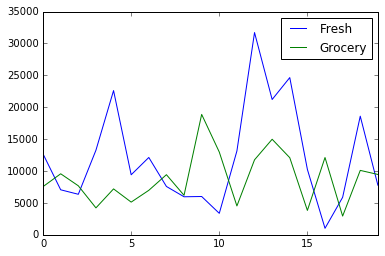

In [185]:
data[['Fresh', 'Grocery']].head(20).plot()

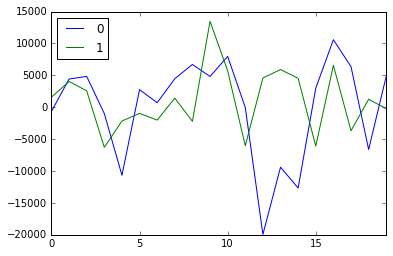

In [186]:
pd.DataFrame(pca.transform(data)).head(20).plot()

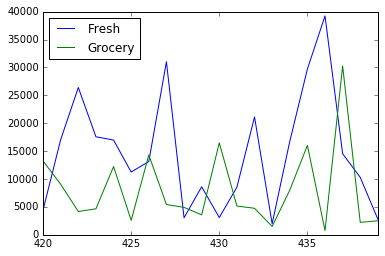

In [187]:
data[['Fresh', 'Grocery']].tail(20).plot()

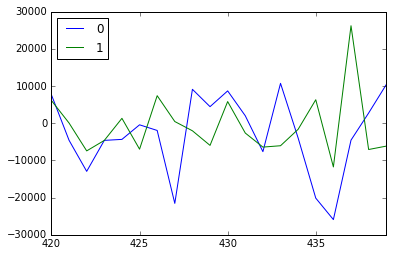

In [188]:
pd.DataFrame(pca.transform(data)).tail(20).plot()

###ICA

In [189]:
means = pd.DataFrame({'Fresh': [12000.30], 
                      'Milk': [5796.27], 
                      'Grocery': [7951.28], 
                      'Frozen': [3071.93], 
                      'Detergents_Paper': [2881.49], 
                      'Delicatessen': [1524.87]})

means

,Delicatessen,Detergents_Paper,Fresh,Frozen,Grocery,Milk
0,1524.87,2881.49,12000.3,3071.93,7951.28,5796.27


In [190]:
columns = ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicatessen']
columns

['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']

In [191]:
centered = pd.DataFrame(data[columns].values - means[columns].values,columns = columns)
centered

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,668.7,3859.73,-390.28,-2857.93,-207.49,-186.87
1,-4943.3,4013.73,1616.72,-1309.93,411.51,251.13
2,-5647.3,3011.73,-267.28,-666.93,634.51,6319.13
3,1264.7,-4600.27,-3730.28,3332.07,-2374.49,263.13
4,10614.7,-386.27,-753.28,843.07,-1104.49,3660.13
5,-2587.3,2462.73,-2825.28,-2405.93,-1086.49,-73.87
6,125.7,-2597.27,-976.28,-2591.93,258.51,-979.87
7,-4421.3,-840.27,1474.72,-1402.93,439.51,1041.13
8,-6037.3,-2148.27,-1759.28,-2646.93,-1165.49,-774.87
9,-5994.3,5296.73,10929.72,-1912.93,4543.51,573.13


In [192]:
data.head(6)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
5,9413,8259,5126,666,1795,1451


In [193]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA

# Transform with ICA and then save to disk so that component ordering does not change.

# ica = FastICA()
# ica_transformed = ica.fit_transform(centered)

# from sklearn.externals import joblib
# joblib.dump(ica, 'ica.pkl') 

# Load saved ICA

ica = joblib.load('ica.pkl') 


# Print the independent components
print ica.components_

[[  2.02003797e-07  -1.79579632e-06   7.10800597e-06   3.20690466e-07
   -2.38146667e-06  -1.75454210e-06]
 [ -1.62061182e-07  -9.82236528e-06   5.84993261e-06   3.68262841e-07
   -3.46678077e-06   5.94869412e-06]
 [  8.62976227e-07   1.34105131e-07  -7.68601760e-07  -1.11471066e-05
    5.38730191e-07   5.97328796e-06]
 [  3.97790968e-06  -8.94497296e-07  -7.34195031e-07  -6.68425774e-07
    2.31283560e-06  -9.64793816e-07]
 [ -3.90303589e-07  -2.64484312e-07  -5.70406958e-07  -5.09399764e-07
    4.94816790e-07   1.81141099e-05]
 [  2.75131459e-07  -2.45442813e-06  -1.16461249e-05   1.48562237e-06
    2.80802618e-05   5.68478441e-06]]


In [194]:
ica

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=None, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

In [195]:
pd.DataFrame(ica_transformed)

,0,1,2,3,4,5
0,-0.009665,-0.041748,0.032024,0.001105,-0.003091,-0.015879
1,0.001445,-0.029581,0.011353,-0.022856,0.005366,-0.019003
2,-0.021261,0.004915,0.041258,-0.029146,0.116679,0.046916
3,-0.011737,0.034183,-0.033509,0.003912,0.004745,-0.005148
4,-0.006038,0.023580,0.021558,0.036474,0.061713,0.003686
5,-0.023082,-0.037857,0.026062,-0.011254,0.001320,-0.008356
6,-0.001977,0.012100,0.023689,0.006816,-0.015106,0.015617
7,0.007775,0.021750,0.017033,-0.016969,0.020898,-0.000153
8,-0.006580,0.010244,0.020103,-0.020981,-0.009336,-0.016964
9,0.054527,-0.000163,0.014332,-0.025373,0.008309,-0.013940


## Independent Component 3 corresponds to "Fresh" Products

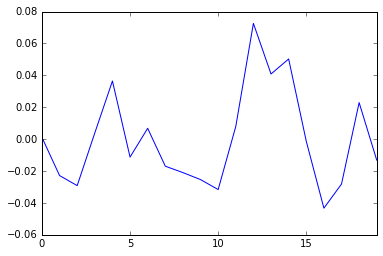

In [221]:
pd.DataFrame(ica_transformed)[3].head(20).plot()

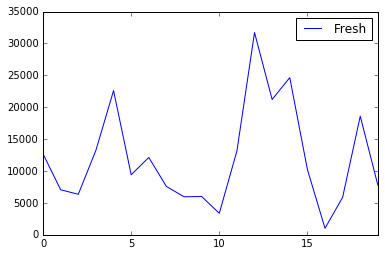

In [197]:
pd.DataFrame(data[['Fresh']].head(20)).plot()

## Independent Component 0 follows the general trend of "Grocery" Products and "Detergents_Paper", and "Milk" Products.

It makes sense that the amount of money spent on grocery products is proportional to the amount of money spent on detergents and paper, and milk products.

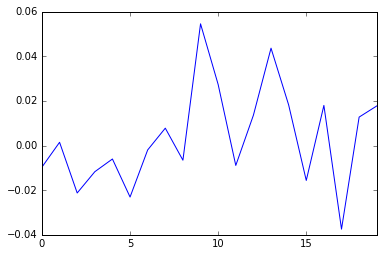

In [228]:
pd.DataFrame(ica_transformed)[0].head(20).plot()

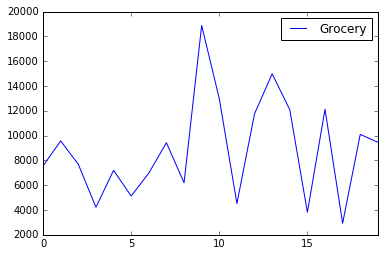

In [199]:
pd.DataFrame(data[['Grocery']].head(20)).plot()

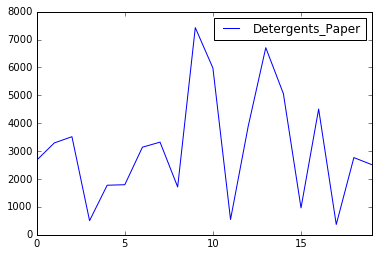

In [200]:
pd.DataFrame(data[['Detergents_Paper']].head(20)).plot()

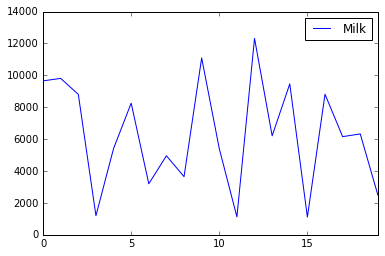

In [206]:
pd.DataFrame(data[['Milk']].head(20)).plot()

## Independent Component 4 follows the general trend of "Delicatessen" products.

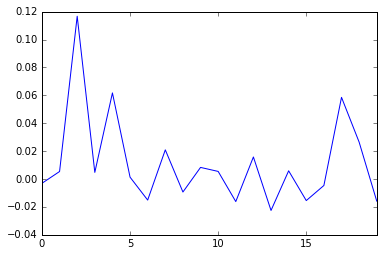

In [232]:
pd.DataFrame(ica_transformed)[4].head(20).plot()

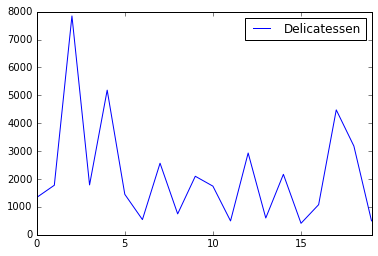

In [202]:
pd.DataFrame(data[['Delicatessen']].head(20)).plot()

## Not sure about the rest...

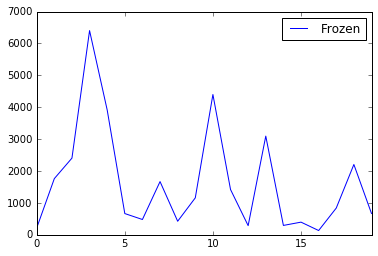

In [203]:
pd.DataFrame(data[['Frozen']].head(20)).plot()

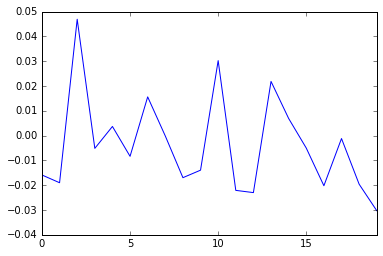

In [235]:
pd.DataFrame(ica_transformed)[5].head(20).plot()

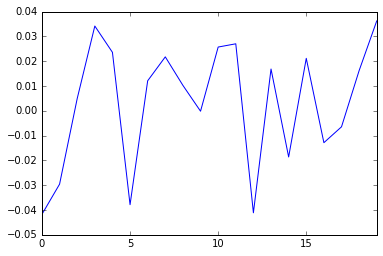

In [205]:
pd.DataFrame(ica_transformed)[1].head(20).plot()

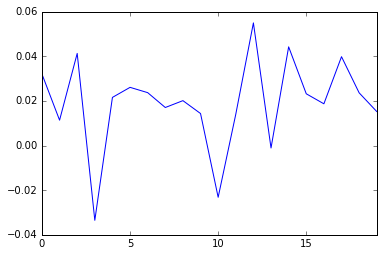

In [236]:
pd.DataFrame(ica_transformed)[2].head(20).plot()

**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 

Each vector in the ICA decomposition is an independent component. ICA maps the data for each customer into new a new basis, where data in the new vectors are statistically independent from one another. ICA is usually used for separating superimposed signals (see http://scikit-learn.org/stable/modules/decomposition.html#ica).

The 3rd independent component seems to correspond to the "fresh" products. The 0th independent component seems to follow the general trends of "grocery" and "detergents_paper" products, and to alesser extent, follows the "milk" products. The 4th independent component seems to be related to "delicatessen." The rest of the independent components are harder to understand and they seem to not be as straightforward.

I suppose we could use these components as a way of representing data to be less noisy, since ICA projects the original data onto a vector space where vectors are statistically independent of each other.

##Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

###Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 

The advantage of K Means Clustering is that it is relatively simple to understand. Once we select a number of clusters (k), the centroids are randomly placed on the feature space and are then iteratively "pulled by rubber bands" toward clumps of points. After several iterations, the centroids have hopefully stabilized on global minima (sometimes they don't), and points in the feature space are assigned to the centroid that is closest to them.

The advantage of Gaussian Mixture Models is that their goals are similar to K Means, but they also take into account covariance structure in the data (see http://scikit-learn.org/stable/modules/mixture.html). Another advantage of Gaussian Mixture Models is that they do soft assignment (i.e. assign a probability to the class of the point of interest) instead classifying the point of interest as to belonging to only one class.  This is nice because it reflects the uncertainty in classifying points that are right in between the decision boundaries, unlike K Means.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [208]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [209]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
reduced_data = pca.transform(data)
print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


In [210]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

def cluster(clusterer):
    clusterer.fit(reduced_data)
    clusters = clusterer
    print clusters
    return clusters

In [211]:
# Plot the decision boundary by building a mesh grid to populate a graph.

def plot_boundary(clusters):
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    hx = (x_max-x_min)/1000.
    hy = (y_max-y_min)/1000.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])
    return Z,xx,yy,x_min,x_max,y_min,y_max

In [212]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

def cluster_means(clusters, func_name):
    centroids = getattr(clusters, func_name)
    print centroids
    return centroids

In [213]:
# Put the result into a color plot
def color_plot(clusters, Z,xx,yy,x_min,x_max,y_min,y_max,centroids):
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [214]:
def cluster_and_plot(clusterer,func_name):
    clusters = cluster(clusterer)
    Z,xx,yy,x_min,x_max,y_min,y_max = plot_boundary(clusters)
    centroids = cluster_means(clusters,func_name)
    color_plot(clusters,Z,xx,yy,x_min,x_max,y_min,y_max,centroids)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[-10810.23008886   9858.15532401]
 [  3308.39301792  -3017.01739698]]


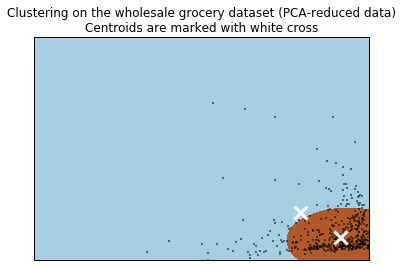

In [215]:
clusterer = GMM(n_components=2)
cluster_and_plot(clusterer, 'means_')

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
[[  4175.31101293   -211.15109304]
 [-24088.33276689   1218.17938291]]


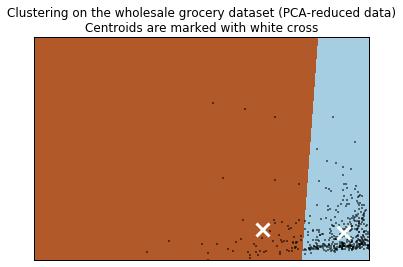

In [216]:
clusterer = KMeans(n_clusters=2)
cluster_and_plot(clusterer, 'cluster_centers_')

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[-17858.6536729   10050.33930164]
 [  7007.45427668   4294.01360677]
 [   313.48539412  -6497.20521133]]


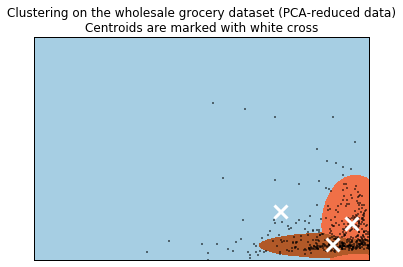

In [217]:
clusterer = GMM(n_components=3)
cluster_and_plot(clusterer, 'means_')

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
[[  4165.1217824   -3105.15811456]
 [-23978.86566553  -4445.56611772]
 [  1341.31124554  25261.39189714]]


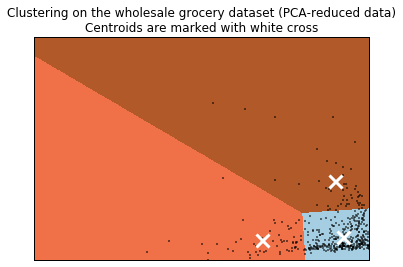

In [218]:
clusterer = KMeans(n_clusters=3)
cluster_and_plot(clusterer, 'cluster_centers_')

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 

Central objects in each cluster represent the centroids. In terms of customers, since they are "smack dab in the middle" of each cluster, they seem to represent the "average" customer in that grouping.

###Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 

I felt that the best techniques to use were to use PCA to summarize the data into two principal components that roughly correspond with "fresh" and "grocery" products respectively. After doing PCA, using Gaussian Mixture Models with 2 or 3 components made sense. With 2 GMM components, I could quickly see that one component captures some sort of "oval" clump, while the other captures everything that's not in the oval clump. Perhaps, these 2 clusters correspond to "big" and "small" businesses.  With 3 GMM components, the rough oval shape became divided into two smaller ovals, while the 3rd component captured everything outside the two ovals. 

In the 3-component clusters using GMM, we can identify 3 groups: one of customers that order lots of fresh products, another of customers that order lots of fresh products AND grocery items, and lastly, one of customers that don't belong in those two groups. My hypothesis is that unhappy customers probably belong to the cluster of customers that predominantly order only fresh products. Since the delivery schedule has changed from morning to evening, and now that it's in bulk, those customers are probably most affected. The products in the "fresh" category are probably not as "fresh" as they used to be. Assuming that they have regular hours of operation (i.e. they have more hours open during the day than during night), this means that the fresh products get stored at night, and probably have to wait till the next day to get bought.  Also, "bulk" deliveries probably means we are not delivering to them as frequently. This further supports the idea that the "fresh" products are likely to become more stale because of the new changes.  I would test this idea out, again, by figuring out how concentrated or spread out the unhappy customers are in the clusters.

**9)** How would you use that technique to help the company design new experiments?

Answer: 

Now that we have some clusters, and given the information that some companies have complaints about the new change, I would try to project the customers that we know have issues with the new change onto the first two principal components as we've done above, and then figure out which cluster they belong. An interesting experiment would be to figure out if these unhappy customers are overwhelmingly concentrated in one cluster.  For example, in the case of three GMM clusters, a null hypothesis could be that customers who have problems should be evenly distributed throughout the three clusters. Once we have gathered enough complaints, we could map each of those customers onto the new projection and test our hypothesis. If we can safely reject the null hypothesis (i.e. unhappy customers overwhelmingly are concentrated in one cluster), we could then reach out to the other customers who belong to that cluster, pay more attention to their needs and maybe give them special offers so that they keep doing business with us (such as restoring the daily morning deliveries).

**10)** How would you use that data to help you predict future customer needs?

Answer: 

After the A/B test, if we got to the point of successfully identifying the cluster that most of the unhappy customers belong to, it's probably likely for those people in that cluster to prefer the old method of delivery. We predict that those customers in that cluster probably like more frequent, morning deliveries. In other words, we could assign them labels based on which cluster they belong to. After that, we could treat this as a supervised learning problem.